In [21]:
!mkdir -p ../wheels/

In [5]:
!wget https://download.pytorch.org/whl/cu111/torch-1.8.0%2Bcu111-cp38-cp38-linux_x86_64.whl ../wheels/
!wget https://download.pytorch.org/whl/cu111/torchvision-0.9.0%2Bcu111-cp38-cp38-linux_x86_64.whl ../wheels/

--2021-03-24 17:39:10--  https://download.pytorch.org/whl/cu111/torch-1.8.0%2Bcu111-cp38-cp38-linux_x86_64.whl
Resolving download.pytorch.org (download.pytorch.org)... 54.192.229.31, 54.192.229.14, 54.192.229.100, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.229.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1982234878 (1.8G) [binary/octet-stream]
Saving to: ‘torch-1.8.0+cu111-cp38-cp38-linux_x86_64.whl’

torch-1.8.0+cu111-c 100%[===================>]   1.85G  11.2MB/s    in 2m 53s  

2021-03-24 17:42:03 (10.9 MB/s) - ‘torch-1.8.0+cu111-cp38-cp38-linux_x86_64.whl’ saved [1982234878/1982234878]

--2021-03-24 17:42:03--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-03-24 17:42:03--
Total wall clock time: 2m 54s
Downloaded: 1 files, 1.8G in 2m 53s (10.9 MB/s)


In [2]:
!pip install \
    /data/wheels/torch-1.8.0+cu111-cp38-cp38-linux_x86_64.whl \
    /data/wheels/torchvision-0.9.0+cu111-cp38-cp38-linux_x86_64.whl \
    efficientnet_pytorch \
    opencv-python \
    pandas \
    tqdm \
    matplotlib

Processing /data/wheels/torch-1.8.0+cu111-cp38-cp38-linux_x86_64.whl
Processing /data/wheels/torchvision-0.9.0+cu111-cp38-cp38-linux_x86_64.whl
torch is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
torchvision is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=f39791770011fdfe2854453441ab3f3e4b6caf13b0a4ee4aa3f2f5288f9408b1
  Stored in directory: /home/jovyan/.cache/pip/wheels/a1/48/0f/c27e70af8f45a2c1d2c2a041e73e0f0ba122d5ef6aa6c2d95c
Successfully built efficientnet-pytorch


In [5]:
from pathlib import Path
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm.notebook import tqdm

In [6]:
# Print model architecture.

def _cell():
    model = resnet18(pretrained=True)
    print(model)

_cell()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
class ImageDataset(Dataset):

    def __init__(self, df: pd.DataFrame, image_folder_path: Path):
        self._df = df
        self._image_folder_path = image_folder_path
        self._resize = transforms.Resize(size=(224, 224))
        self._normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    def __len__(self) -> int:
        return len(self._df)

    def _load_image(self, img_name: str) -> torch.Tensor:
        img = torch.from_numpy(
            cv2.cvtColor(
                cv2.imread(str(self._image_folder_path / img_name)),
                cv2.COLOR_BGR2RGB).transpose(2, 0, 1))
        return self._normalize(self._resize(img) / 255.0)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        row = self._df.iloc[idx]
        img1_name, lg_id = row['image'], row['label_group']
        if idx % 2 == 0:
            # pick from other label group
            candidates: pd.DataFrame = self._df.loc[self._df.label_group != lg_id]
        else:
            # pick from same label group
            candidates: pd.DataFrame = self._df.loc[(self._df.label_group == lg_id) & (self._df.image != img1_name)]
        img2_name = candidates.sample(n=1).image.item()
        return self._load_image(img1_name), self._load_image(img2_name), torch.tensor([idx % 2])


In [4]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        model = resnet18(pretrained=True)
        model.fc = torch.nn.Identity()
        self._model = model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._model(x)

In [5]:
train_df = pd.read_csv('/data/train.csv')

In [16]:
import gc
gc.collect(); torch.cuda.empty_cache()

  0%|          | 0/1071 [00:00<?, ?it/s]

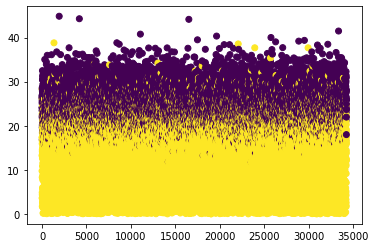

In [10]:
# Show distance values

def _cell():
    batch_size = 32
    
    model = Model()
    model = model.cuda()
    model.eval()

    distance_tensor, color_tensor = None, None
    dataset = ImageDataset(df=train_df, image_folder_path=Path('/data/train_images'))
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=8, pin_memory=True)
    with torch.no_grad():
        for x1, x2, y in tqdm(dataloader, total=len(dataloader)):
            x1, x2 = x1.cuda(), x2.cuda()
            v = model(torch.cat([x1, x2], dim=0))
            split_idx = int(v.shape[0] / 2)
            v1, v2 = v[:split_idx, ...], v[split_idx:, ...]
            dist = torch.cdist(torch.unsqueeze(v1, dim=1), torch.unsqueeze(v2, dim=1)).squeeze()
            y = y.squeeze()
            distance_tensor = torch.cat([distance_tensor, dist], axis=0) if distance_tensor is not None else dist
            color_tensor = torch.cat([color_tensor, y], axis=0) if color_tensor is not None else y
    
    plt.scatter(
        x=list(range(len(distance_tensor))),
        y=distance_tensor.cpu().numpy(),
        c=color_tensor.cpu().numpy())

_cell()

In [8]:
# Try different thresholds and pick the best one

def _cell():
    for threshold in range(18, 23):
        threshold = float(threshold)
        batch_size = 32

        model = Model()
        model = model.cuda()
        model.eval()

        num_correct = 0.0
        dataset = ImageDataset(df=train_df, image_folder_path=Path('/data/train_images'))
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=16, pin_memory=True)
        with torch.no_grad():
            for x1, x2, y in tqdm(dataloader, total=len(dataloader)):
                x1, x2, y = x1.cuda(), x2.cuda(), y.cuda()
                v = model(torch.cat([x1, x2], dim=0))
                split_idx = int(v.shape[0] / 2)
                v1, v2 = v[:split_idx, ...], v[split_idx:, ...]
                dist = torch.cdist(torch.unsqueeze(v1, dim=1), torch.unsqueeze(v2, dim=1)).squeeze()
                y_pred = (dist < threshold).int()
                y = y.squeeze()
                num_correct += (y == y_pred).float().sum().item()

        print(f'accuracy = {num_correct / len(dataset)}, threshold = {threshold}')

_cell()

  0%|          | 0/1071 [00:00<?, ?it/s]

accuracy = 0.8087591240875912, threshold = 18.0


  0%|          | 0/1071 [00:00<?, ?it/s]

accuracy = 0.8305985401459854, threshold = 19.0


  0%|          | 0/1071 [00:00<?, ?it/s]

accuracy = 0.8451094890510948, threshold = 20.0


  0%|          | 0/1071 [00:00<?, ?it/s]

accuracy = 0.8461313868613138, threshold = 21.0


  0%|          | 0/1071 [00:00<?, ?it/s]

accuracy = 0.832963503649635, threshold = 22.0


In [14]:
class ImageTestPairDataset(Dataset):

    def __init__(self, df: pd.DataFrame, image_folder_path: Path):
        self._df = df
        self._image_folder_path = image_folder_path
        self._resize = transforms.Resize(size=(224, 224))
        self._normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    def __len__(self) -> int:
        return len(self._df)

    def _load_image(self, img_name: str) -> torch.Tensor:
        img = torch.from_numpy(cv2.imread(str(self._image_folder_path / img_name)).transpose(2, 0, 1))
        return self._normalize(self._resize(img) / 255.0)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        row = self._df.iloc[idx]
        img_name_1, lg_1 = row['image_1'], row['label_group_1']
        img_name_2, lg_2 = row['image_2'], row['label_group_2']
        return self._load_image(img_name_1), self._load_image(img_name_2), torch.tensor([int(lg_1 == lg_2)])

In [10]:
test_pair_df = pd.read_csv('/data/test_pairs.csv')

In [15]:
# Measure the baseline performance on the test pair set.

def _cell():
    threshold = 21.0
    batch_size = 32

    model = Model()
    model = model.cuda()
    model.eval()

    num_correct = 0.0
    dataset = ImageTestPairDataset(df=test_pair_df, image_folder_path=Path('/data/train_images'))
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=8, pin_memory=True)
    with torch.no_grad():
        for x1, x2, y in tqdm(dataloader, total=len(dataloader)):
            x1, x2, y = x1.cuda(), x2.cuda(), y.cuda()
            v = model(torch.cat([x1, x2], dim=0))
            split_idx = int(v.shape[0] / 2)
            v1, v2 = v[:split_idx, ...], v[split_idx:, ...]
            dist = torch.cdist(torch.unsqueeze(v1, dim=1), torch.unsqueeze(v2, dim=1)).squeeze()
            y_pred = (dist < threshold).int()
            y = y.squeeze()
            num_correct += (y == y_pred).float().sum().item()

    print(f'accuracy = {num_correct / len(dataset)}')

_cell()

  0%|          | 0/1628 [00:00<?, ?it/s]

accuracy = 0.8354962564791707
